In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import jieba
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import re
import gensim

from torchtext import data, datasets

10W条数据按`0.6：0.2：0.2`切分成训练集，验证集，测试集

In [2]:
train_df = pd.read_csv(r'nCoV_100k_train.labled.csv', encoding='utf-8', error_bad_lines=False)
test_online_df= pd.read_csv(r'nCov_10k_test.csv', encoding='utf-8')

In [3]:
print(train_df.情感倾向.value_counts())
train_df = train_df[(train_df.情感倾向 == '1') | (train_df.情感倾向 == '0') | (train_df.情感倾向 == '-1')]
train_df['情感倾向'] = train_df.情感倾向.map({'-1':'0', '0':'1', '1':'2'})

0     57619
1     25392
-1    16902
10        1
9         1
-         1
-2        1
·         1
4         1
Name: 情感倾向, dtype: int64


In [4]:
train_df['微博中文内容'].fillna('缺失', inplace=True)
test_online_df['微博中文内容'].fillna('缺失', inplace=True)
train_df, test_df = train_test_split(train_df, test_size=0.15, shuffle=True, random_state=4)
train_df, dev_df = train_test_split(train_df, test_size=0.15, shuffle=True, random_state=4)

train_df.to_csv('./train.csv', index=False)
dev_df.to_csv('./dev.csv', index=False)
test_df.to_csv('./test.csv', index=False)
test_online_df.to_csv('./test_online.csv', index=False)

# 使用torchtext对文本进行预处理

torchtext预处理流程：

1. 定义Field：声明如何处理数据  
2. 定义Dataset：得到数据集，此时数据集里每一个样本是一个 经过 Field声明的预处理 预处理后的 wordlist
3. 建立vocab：在这一步建立词汇表，词向量(word embeddings)
4. 构造迭代器：构造迭代器，用来分批次训练模型

TEXT.vocab类的三个variables,可以返回我们需要的属性。

- `reqs` 用来返回每一个单词和其对应的频数。
- `itos` 按照下标的顺序返回每一个单词
- `stoi` 返回每一个单词与其对应的下标


In [5]:
import re
from torchtext import data
from torchtext import vocab
from torchtext.vocab import Vectors

def tokenizer(text):
    #去掉不在(所有中文、大小写字母、数字)中的非法字符
    regex = re.compile(u'[a-zA-Z0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~，。、c【】：”（）；]+')
    text = re.sub(regex, '', text)
        
    word_list = [word for word in jieba.cut(text) if word.strip()]
    if len(word_list) == 0:
        word_list.append('缺失')
    #使用jieba分词
    return word_list

In [74]:
t = '2ausical真的吗2。'

regex = re.compile(u'[a-zA-Z0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~，。、c【】：”（）；]+')
re.sub(regex, '', t) 

In [159]:
TEXT = data.Field(lower=True, tokenize = tokenizer, include_lengths=True)
LABEL = data.Field(sequential=False, use_vocab=False, dtype=torch.long, is_target=True)
ID = data.Field(sequential=False, use_vocab=False)


#创建表格数据集
train, val, test = data.TabularDataset.splits(
    path = './', format = 'csv', skip_header = True,
    train='train.csv', validation='dev.csv', test='test.csv',
    fields=[('微博id',None),
             ('微博发布时间',None),
             ('发布人账号',None),
             ('微博中文内容', TEXT),
             ('微博图片',None),
             ('微博视频',None),
             ('情感倾向', LABEL)]
)
# 线上测试集
test_online = data.TabularDataset(
    path='./test_online.csv', format = 'csv', skip_header = True,
    fields=[('微博id',ID),
               ('微博发布时间',None),
               ('发布人账号',None),
               ('微博中文内容', TEXT),
               ('微博图片',None),
               ('微博视频',None)]
)

####
# 更进一步的，可以在指定name的同时同时指定缓存文件所在目录，而不是使用默认的.vector_cache目录
cache = '.vector_cache'
if not os.path.exists(cache):
    os.mkdir(cache)
vectors = Vectors(name='./Pre_train_word_embedding/sgns.weibo.word', cache=cache)
####
TEXT.build_vocab(train, max_size=80000, min_freq=5)
LABEL.build_vocab(train)

train_iter, val_iter, test_iter = data.Iterator.splits(
        (train, val, test), 
        sort_key=lambda x: len(x.微博中文内容),
        sort_within_batch=True,
#         sort=True,
        batch_sizes=(32,32,32), 
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
test_online_iter = data.Iterator(
        test_online, 
        batch_size=32, 
        sort_key=lambda x: len(x.微博中文内容),
        sort_within_batch=True,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# batch = next(iter(train_iter))
# print("batch text: ", batch.微博中文内容) # 对应 Fileld 的 name
# print("batch label: ", batch.情感倾向)

In [167]:
len(TEXT.vocab.itos)

31521

In [166]:
len(TEXT.vocab.stoi)

31521

In [97]:
len(TEXT.vocab.stoi)

6335

In [162]:
len(TEXT.vocab.freqs)

121880

In [131]:
for i, batch in enumerate(test_online_iter):
    if i ==1: 
        print(batch.微博id.device)

cuda:0


# 预训练词向量

In [7]:
train_unlabeld_df = pd.read_csv(r'nCoV_900k_train.unlabled.csv', encoding='utf-8', error_bad_lines=False)
list_train_unlabeld = train_unlabeld_df['微博中文内容'].tolist()

print('begin')
list_text = list(map(tokenizer, list_train_unlabeld))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


begin


Loading model cost 0.620 seconds.
Prefix dict has been built successfully.


**保存`**

In [117]:
# file= open('text.txt', 'w')  
# for fp in list_text:
#     file.write(str(fp))
#     file.write('\n')
# file.close()

# 读取
file=open('text.txt', 'r')
list_read = file.readlines()

**开始训练**

**Fasttext** 

In [8]:
from gensim.models import FastText
model_fasttext = FastText(list_text,  size=4, window=3, min_count=1, iter=10,min_n = 3 , max_n = 6,word_ngrams = 0)

In [ ]:
len(model_fasttext.wv.vocab.keys())

**wordtovec**

In [152]:
wv_model = gensim.models.Word2Vec(list_text)

In [153]:
wv_model.itos = {}
wv_model.stoi = {}
wv_model.embedding = {}

for k in tqdm(wv_model.wv.vocab.keys()):
    wv_model.itos[wv_model.wv.vocab[k].index] = k
    wv_model.stoi[k] = wv_model.wv.vocab[k].index
    wv_model.embedding[wv_model.wv.vocab[k].index] = wv_model.wv[k]

100%|██████████| 125754/125754 [00:00<00:00, 184226.85it/s]


In [163]:
vocab_sIze = len(TEXT.vocab.itos)
pre_weight = torch.zeros(vocab_sIze, 100)
list_word_embed =  list(TEXT.vocab.stoi.keys())
print(vocab_sIze)

for i in range(len(wv_model.itos)):
    word = wv_model.itos[i]
    if word in list_word_embed:
        word_index_in_TEXT = TEXT.vocab.stoi[word]
        pre_weight[word_index_in_TEXT] =torch.from_numpy(wv_model.embedding[i])

31521


In [165]:
pre_weight

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.6160e+00,  1.5643e+00, -2.8142e+00,  ...,  1.9609e+00,
          1.8061e+00,  5.5235e-01],
        ...,
        [-2.1219e-03,  1.3642e-02,  3.1980e-01,  ...,  8.6487e-03,
         -2.9823e-01, -4.7347e-02],
        [-2.1960e-01, -1.1830e-01,  6.9046e-01,  ..., -7.0895e-01,
         -7.0760e-01,  2.7423e-01],
        [-2.9129e-02, -4.1345e-02,  2.3483e-01,  ..., -2.8768e-01,
         -2.0562e-01, -1.1388e-01]])

In [164]:
len(wv_model.itos)

125754

# 定义训练函数和评估函数

In [168]:
def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f'The model has {count_parameters(model):,} trainable parameters')

In [169]:
def train_func(model, iterator):
    train_loss = 0
    train_acc = 0
    model.train()
    output_list = []
    cls_list = []
    for i, batch in enumerate(iterator):
        optimizer.zero_grad() 
        text, cls = batch.微博中文内容[0], batch.情感倾向
        lengths = batch.微博中文内容[1]
        output = model(text, lengths) # [B, OUTPUT_SIZE]
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step() # update
        
        train_loss += loss.item()
        _, output = torch.max(output, 1)
        output_list += output.cpu().numpy().tolist()
        cls_list      += cls.cpu().numpy().tolist()
        
    # Adjust the learning rate
    scheduler.step()
    
    return train_loss/len(iterator), output_list, cls_list

def evaluate(model, iterator):
    val_loss = 0
    model.eval()
    output_list = []
    cls_list = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            text, cls = batch.微博中文内容[0], batch.情感倾向
            lengths = batch.微博中文内容[1]
            output = model(text, lengths) # [B, OUTPUT_SIZE]
            loss = criterion(output, cls)
            val_loss += loss.item()
            _, output = torch.max(output, 1)
            output_list += output.cpu().numpy().tolist()
            cls_list      += cls.cpu().numpy().tolist()
    return val_loss/len(iterator), output_list, cls_list

def evaluation_indicators(loss, pre_list, cls_list):
    print('\tLoss: {:.4f}'.format(loss))
    print('\tprecison_score：', precision_score(pre_list, cls_list, average=None, labels=[0,1,2]))
    print('\trecall_score：', recall_score(pre_list, cls_list, average=None, labels=[0,1,2]))
    print('\tf1_score：', f1_score(pre_list, cls_list, average=None, labels=[0,1,2]))
    print('\tf1_score：', f1_score(pre_list, cls_list, average='macro', labels=[0,1,2]))
    sns.heatmap(confusion_matrix(pre_list, cls_list), annot=True)
    plt.show()   
    return f1_score(pre_list, cls_list, average='macro', labels=[0,1,2])

# Get_result()

In [170]:
def get_result(model, iterator):
    model.eval()
    result = torch.Tensor().cuda()
    ID = torch.LongTensor().cuda()
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            text = batch.微博中文内容[0]
            lengths = batch.微博中文内容[1]
            batch_id = batch.微博id
            ID = torch.cat((ID, batch_id), dim=0)
            output = model(text, lengths)
            result = torch.cat((result, output), dim=0)
    
    result = result.cpu().numpy()
    ID = ID.cpu().numpy()
    result = result.argmax(axis=1)
    result = pd.DataFrame({'测试数据id': ID, '情感极性':result})    
    result['情感极性'] = result.情感极性.map({0:-1, 1:0, 2:1})
    return result

In [89]:
result = get_result(model_word_avg, test_online_iter)
result.to_csv(r'./result.csv', index=False)

In [52]:
result.情感极性.value_counts(normalize=True)

 0    0.6855
 1    0.2025
-1    0.1120
Name: 情感极性, dtype: float64

In [51]:
train_df.情感倾向.value_counts(normalize=True)

1    0.577195
2    0.254173
0    0.168631
Name: 情感倾向, dtype: float64

# Word Averaging模型

- 我们首先介绍一个简单的Word Averaging模型。这个模型非常简单，我们把每个单词都通过`Embedding`层投射成word embedding vector，然后把一句话中的所有word vector做个平均，就是整个句子的vector表示了。接下来把这个sentence vector传入一个`Linear`层，做分类即可。

- 我们使用[`avg_pool2d`](https://pytorch.org/docs/stable/nn.html?highlight=avg_pool2d#torch.nn.functional.avg_pool2d)来做average pooling。我们的目标是把sentence length那个维度平均成1，然后保留embedding这个维度。

- `avg_pool2d`的kernel size是 (`embedded.shape[1]`, 1)，所以句子长度的那个维度会被压扁。

## 定义模型

In [179]:
class Word_AVGModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, output_size, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=pad_idx)
        self.fc = nn.Linear(embedding_size, output_size)
        self.drop = nn.Dropout(0.2)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text) # [L, B, EMB_SIZE] 
        embedded = embedded.permute(1, 0, 2) # [B, L, EMB_SIZE] 
#         pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) # [B, EMB_SIZE] 
        pooled = torch.mean(embedded, dim=1) # [B, EMB_SIZE]
        pooled = self.drop(pooled)
        out = self.fc(pooled) # [B, OUTPUT_SIZE]
        return out

In [180]:
device = "cuda" if torch.cuda.is_available() else "cpu"

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_SIZE = 100
OUTPUT_SIZE = 3
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model_word_avg = Word_AVGModel(INPUT_DIM, EMBEDDING_SIZE, OUTPUT_SIZE, PAD_IDX).to(device)

# 导入预训练的词向量
# weight_matrix = TEXT.vocab.vectors  
model_word_avg.embedding.weight.data.copy_(pre_weight )  

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.6160e+00,  1.5643e+00, -2.8142e+00,  ...,  1.9609e+00,
          1.8061e+00,  5.5235e-01],
        ...,
        [-2.1219e-03,  1.3642e-02,  3.1980e-01,  ...,  8.6487e-03,
         -2.9823e-01, -4.7347e-02],
        [-2.1960e-01, -1.1830e-01,  6.9046e-01,  ..., -7.0895e-01,
         -7.0760e-01,  2.7423e-01],
        [-2.9129e-02, -4.1345e-02,  2.3483e-01,  ..., -2.8768e-01,
         -2.0562e-01, -1.1388e-01]], device='cuda:0')

有预训练的话可以引入预训练向量

In [181]:
# pretrained_embeddings = TEXT.vocab.vectors
# model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model_word_avg.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_SIZE)
model_word_avg.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_SIZE)

## 训练模型

In [233]:
weight = train_df.情感倾向.value_counts().to_dict()
weight = sorted(weight.items(), key = lambda items:items[0])
weight = [x[1] for x in weight]

weight = [x / (np.array(weight).sum()) for x in weight]
weight = 1 / torch.Tensor(weight)

weight


tensor([5.9301, 1.7325, 3.9343])


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  | time in 0 minutes, 6 seconds
	 训练集
	Loss: 1.8399
	precison_score： [0.70360634 0.55685691 0.70612601]
	recall_score： [0.4235905  0.78589574 0.57725896]
	f1_score： [0.52881795 0.65184228 0.63522259]
	f1_score： 0.6052942753884496


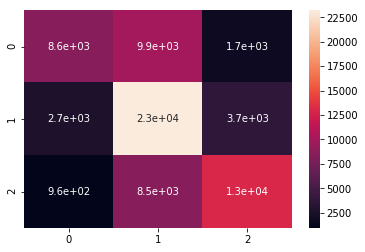

	 验证集
	Loss: 1.5456
	precison_score： [0.79564033 0.4693484  0.75899939]
	recall_score： [0.40499307 0.81487682 0.5879017 ]
	f1_score： [0.53676471 0.59562937 0.66258322]
	f1_score： 0.5983257662939655


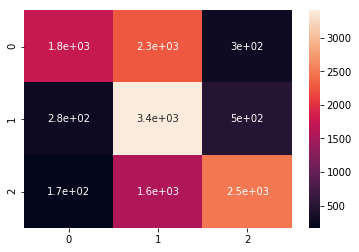


 10%|█         | 1/10 [00:08<01:20,  8.90s/it]

-----------------------------------------------------------------------------------------------------
best_valid_f1_score： 0.5983257662939655
保存模型
Epoch: 2  | time in 0 minutes, 6 seconds
	 训练集
	Loss: 1.8031
	precison_score： [0.7073852  0.56009696 0.70312841]
	recall_score： [0.42813106 0.78507031 0.57727761]
	f1_score： [0.53342006 0.65377073 0.63401809]
	f1_score： 0.6070696247197191


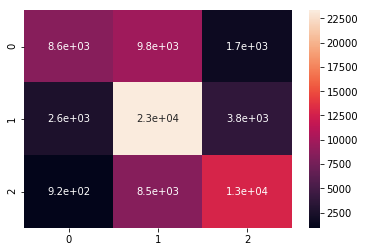

	 验证集
	Loss: 1.2530
	precison_score： [0.7938238  0.56536713 0.70774863]
	recall_score： [0.43580155 0.81090694 0.63266976]
	f1_score： [0.56269113 0.66623377 0.66810655]
	f1_score： 0.6323438164027063


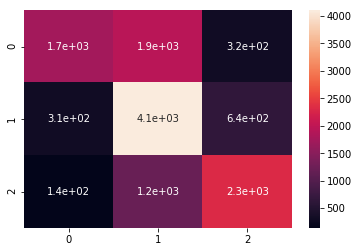


 20%|██        | 2/10 [00:16<01:07,  8.41s/it]

-----------------------------------------------------------------------------------------------------
Epoch: 3  | time in 0 minutes, 6 seconds
	 训练集
	Loss: 1.7133
	precison_score： [0.72093978 0.56928911 0.71342926]
	recall_score： [0.43976749 0.79275425 0.58673241]
	f1_score： [0.54629774 0.66269015 0.64390772]
	f1_score： 0.6176318695083693


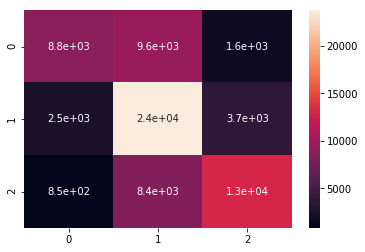

	 验证集
	Loss: 1.2110
	precison_score： [0.70118074 0.6502273  0.70469799]
	recall_score： [0.48584015 0.78877005 0.64579256]
	f1_score： [0.5739777  0.71282942 0.67396061]
	f1_score： 0.6535892423915391


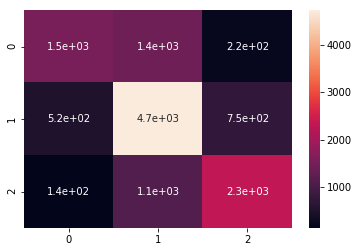


 30%|███       | 3/10 [00:23<00:56,  8.13s/it]

-----------------------------------------------------------------------------------------------------
Epoch: 4  | time in 0 minutes, 5 seconds
	 训练集
	Loss: 1.6403
	precison_score： [0.73112626 0.57821725 0.72269457]
	recall_score： [0.44649576 0.80119721 0.59772809]
	f1_score： [0.55441351 0.67168507 0.65429784]
	f1_score： 0.62679880382604


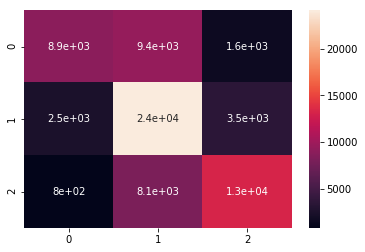

	 验证集
	Loss: 1.2561
	precison_score： [0.67302452 0.59195481 0.79896278]
	recall_score： [0.50237288 0.81444276 0.58032351]
	f1_score： [0.57531056 0.68560032 0.67231421]
	f1_score： 0.6444083622716873


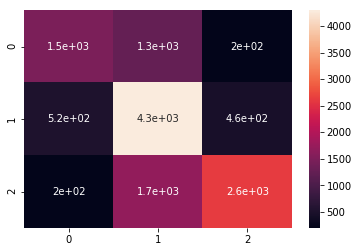


 40%|████      | 4/10 [00:30<00:47,  7.83s/it]

-----------------------------------------------------------------------------------------------------
Epoch: 5  | time in 0 minutes, 5 seconds
	 训练集
	Loss: 1.5829
	precison_score： [0.73966976 0.58313733 0.72847177]
	recall_score： [0.45253053 0.80653942 0.60302278]
	f1_score： [0.56152167 0.6768815  0.65983758]
	f1_score： 0.6327469191981606


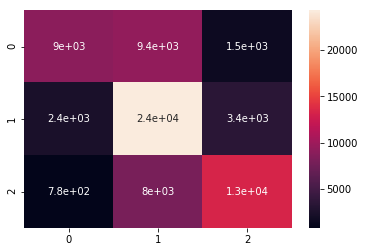

	 验证集
	Loss: 1.1348
	precison_score： [0.79564033 0.59842954 0.65771812]
	recall_score： [0.46226913 0.79168945 0.62276141]
	f1_score： [0.58477971 0.68162561 0.63976261]
	f1_score： 0.635389308528297


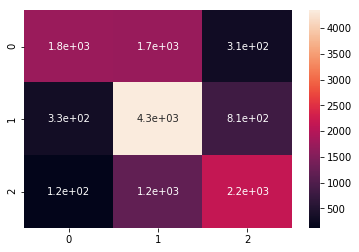


 50%|█████     | 5/10 [00:37<00:37,  7.51s/it]

-----------------------------------------------------------------------------------------------------
Epoch: 6  | time in 0 minutes, 6 seconds
	 训练集
	Loss: 1.5440
	precison_score： [0.74854185 0.58781741 0.73413996]
	recall_score： [0.45844234 0.8103762  0.60983339]
	f1_score： [0.56862929 0.6813838  0.66623801]
	f1_score： 0.6387503640558974


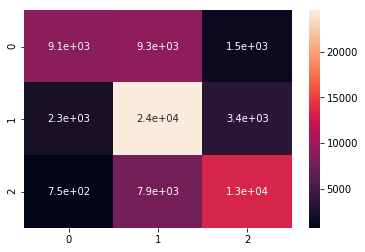

	 验证集
	Loss: 1.1272
	precison_score： [0.62125341 0.65890619 0.76540574]
	recall_score： [0.53146853 0.80117253 0.59809297]
	f1_score： [0.57286432 0.72310832 0.67148401]
	f1_score： 0.6558188844440005


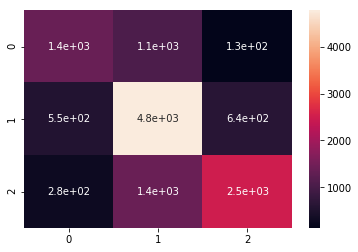


 60%|██████    | 6/10 [00:44<00:29,  7.49s/it]

-----------------------------------------------------------------------------------------------------
Epoch: 7  | time in 0 minutes, 6 seconds
	 训练集
	Loss: 1.5212
	precison_score： [0.75289575 0.58949743 0.73691956]
	recall_score： [0.45880056 0.81517374 0.61236413]
	f1_score： [0.5701577  0.68420686 0.66889285]
	f1_score： 0.6410858035824689


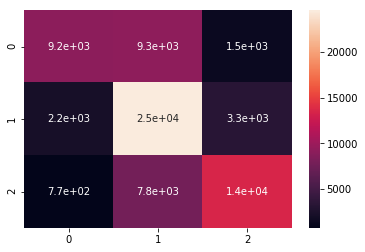

	 验证集
	Loss: 1.1096
	precison_score： [0.79336966 0.55999449 0.77608298]
	recall_score： [0.46058529 0.83987603 0.6195811 ]
	f1_score： [0.58281902 0.67195636 0.68905742]
	f1_score： 0.6479442657760269


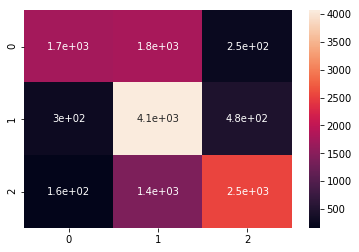


 70%|███████   | 7/10 [00:52<00:22,  7.44s/it]

-----------------------------------------------------------------------------------------------------
Epoch: 8  | time in 0 minutes, 6 seconds
	 训练集
	Loss: 1.4843
	precison_score： [0.76439662 0.59715355 0.74454981]
	recall_score： [0.47054362 0.81912757 0.61991197]
	f1_score： [0.58250908 0.69074555 0.67653832]
	f1_score： 0.6499309812024842


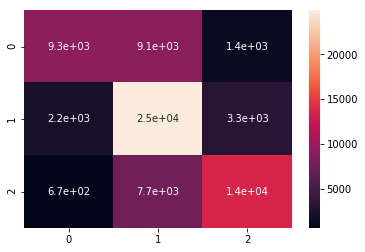

	 验证集
	Loss: 1.0549
	precison_score： [0.79473206 0.58740873 0.74527151]
	recall_score： [0.46149789 0.82973341 0.64154412]
	f1_score： [0.58391725 0.68785288 0.68952865]
	f1_score： 0.6537662593729986


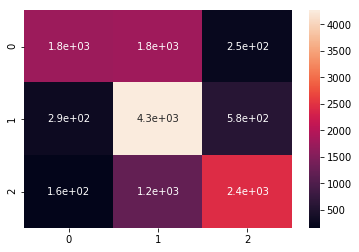


 80%|████████  | 8/10 [00:59<00:14,  7.43s/it]

-----------------------------------------------------------------------------------------------------
Epoch: 9  | time in 0 minutes, 6 seconds
	 训练集
	Loss: 1.4601
	precison_score： [0.76842192 0.60051361 0.74275125]
	recall_score： [0.47132924 0.82100669 0.62327921]
	f1_score： [0.58427808 0.69365973 0.67779076]
	f1_score： 0.6519095252393511


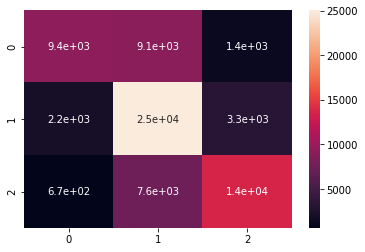

	 验证集
	Loss: 1.0758
	precison_score： [0.69709355 0.65559994 0.76784625]
	recall_score： [0.52912789 0.80921612 0.63608795]
	f1_score： [0.6016069  0.72435312 0.69578438]
	f1_score： 0.6739147998752157


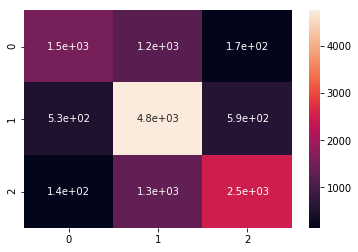


 90%|█████████ | 9/10 [01:07<00:07,  7.42s/it]

-----------------------------------------------------------------------------------------------------
Epoch: 10  | time in 0 minutes, 6 seconds
	 训练集
	Loss: 1.4458
	precison_score： [0.77343301 0.60423367 0.74967299]
	recall_score： [0.47442681 0.82622822 0.628915  ]
	f1_score： [0.58810669 0.69800518 0.68400507]
	f1_score： 0.6567056489319225


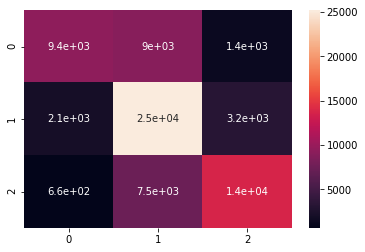

	 验证集
	Loss: 1.0053
	precison_score： [0.79200727 0.62212426 0.7114094 ]
	recall_score： [0.47135135 0.81457431 0.66723891]
	f1_score： [0.59098611 0.70545966 0.68861657]
	f1_score： 0.6616874433577217


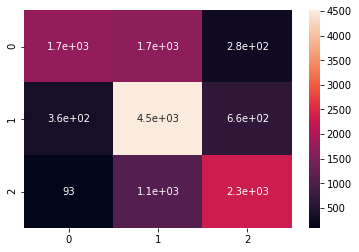


100%|██████████| 10/10 [01:14<00:00,  7.39s/it]


-----------------------------------------------------------------------------------------------------
	 线下测试集
	Loss: 0.9951
	precison_score： [0.79540958 0.61410168 0.70180563]
	recall_score： [0.45650693 0.81636086 0.65356083]
	f1_score： [0.58008658 0.70093213 0.67682458]
	f1_score： 0.652614429820716


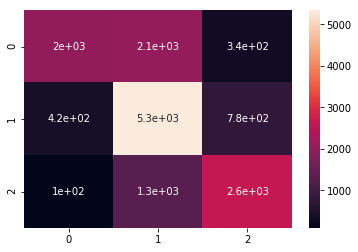

0.652614429820716

In [234]:
N_EPOCHS = 10
best_valid_f1_score = float('inf')

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss(weight=weight).to(device)
optimizer = torch.optim.SGD(model_word_avg.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)


for epoch in tqdm(range(N_EPOCHS)):

    start_time = time.time()
    train_loss, train_output, train_cls = train_func(model_word_avg, train_iter)
    valid_loss, val_output, val_cls = evaluate(model_word_avg, val_iter)    
    
    
    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60
    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print('\t 训练集')
    _ = evaluation_indicators(train_loss, train_output, train_cls)
    print('\t 验证集')
    valid_f1_score = evaluation_indicators(valid_loss, val_output, val_cls)
    print('-----------------------------------------------------------------------------------------------------')
    if valid_f1_score < best_valid_f1_score:
        best_valid_f1_score = valid_f1_score
        print('best_valid_f1_score：', best_valid_f1_score)
        print('保存模型')
        torch.save(model_word_avg.state_dict(), 'model_word_avg.pt')
    
test_loss, test_output, test_cls = evaluate(model_word_avg, test_iter)    
print('\t 线下测试集')
evaluation_indicators(test_loss, test_output, test_cls)

## test_online

In [30]:
result = get_result(model_word_avg, test_online_iter)

In [54]:
result.columns

Index(['测试数据id', '情感极性'], dtype='object')

In [38]:
result.情感极性.value_counts(normalize=True)

 0    0.6194
 1    0.2201
-1    0.1605
Name: 情感极性, dtype: float64

In [40]:
train_df.情感倾向.value_counts(normalize=True)

1    0.577195
2    0.254173
0    0.168631
Name: 情感倾向, dtype: float64

In [32]:
result.to_csv(r'./result.csv', index=False)

# RNN模型

- 下面我们尝试把模型换成一个**recurrent neural network** (RNN)。RNN经常会被用来encode一个sequence
$$h_t = \text{RNN}(x_t, h_{t-1})$$
- 我们使用最后一个hidden state $h_T$来表示整个句子。
- 然后我们把$h_T$通过一个线性变换$f$，然后用来预测句子的情感。

![](assets/sentiment1.png)

![](assets/sentiment7.png)

## 定义模型

In [183]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, n_layers, bidirectional, dropout,pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=pad_idx)
        self.rnn = nn.LSTM(embedding_size, 
                           hidden_size, 
                           num_layers=n_layers,
                          bidirectional=bidirectional,
                          dropout=dropout,
                          batch_first = True)
        self.fc = nn.Linear(hidden_size*2, output_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, seq_length):
        embedded = self.dropout(self.embedding(text)) # [L, B, EMB_SIZE]
        embedded = embedded.permute(1, 0, 2) # [B, L, EMB_SIZE] 
        
        input_pack = nn.utils.rnn.pack_padded_sequence(embedded, seq_length, batch_first=True)
        
        output, (hidden, cell) = self.rnn(input_pack) 
        
#         out_unpack = nn.utils.rnn.pad_packed_sequence(output, batch_fist=True)
        # output = [B, H, hid dim * num directions]
        # hidden = [num layers * num directions, B, hid dim]
        # cell = [num layers * num directions, B, hid dim]
    
    
        # 将最后双向的LSTM拼接起来
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)) # [B, hid dim * num directions]
        return self.fc(hidden.squeeze(0))

In [236]:
device = "cuda" if torch.cuda.is_available() else "cpu"

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_SIZE = 100
HIDDEN_DIM = 160
OUTPUT_SIZE = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model_rnn = RNN(INPUT_DIM, EMBEDDING_SIZE, HIDDEN_DIM, OUTPUT_SIZE, 
            N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX).to(device)

# 导入预训练的词向量
# weight_matrix = TEXT.vocab.vectors  
model_rnn.embedding.weight.data.copy_(pre_weight )  

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.6160e+00,  1.5643e+00, -2.8142e+00,  ...,  1.9609e+00,
          1.8061e+00,  5.5235e-01],
        ...,
        [-2.1219e-03,  1.3642e-02,  3.1980e-01,  ...,  8.6487e-03,
         -2.9823e-01, -4.7347e-02],
        [-2.1960e-01, -1.1830e-01,  6.9046e-01,  ..., -7.0895e-01,
         -7.0760e-01,  2.7423e-01],
        [-2.9129e-02, -4.1345e-02,  2.3483e-01,  ..., -2.8768e-01,
         -2.0562e-01, -1.1388e-01]], device='cuda:0')

In [237]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model_rnn.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_SIZE)
model_rnn.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_SIZE)

print(f'The model_rnn has {count_parameters(model_rnn):,} trainable parameters')

The model_rnn has 4,105,383 trainable parameters


## 训练模型

Epoch: 1  | time in 0 minutes, 55 seconds
	 训练集
	Loss: 19.2693
	precison_score： [0.37180646 0.36696587 0.38848921]
	recall_score： [0.19579512 0.60612067 0.29893059]
	f1_score： [0.25651053 0.45715482 0.33787595]
	f1_score： 0.3505137650221397


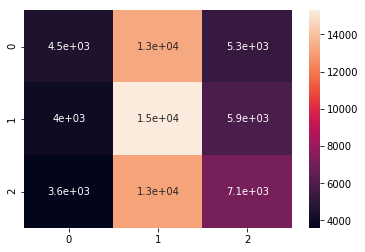

	 验证集
	Loss: 13.1531
	precison_score： [0.21980018 0.84501998 0.04057352]
	recall_score： [0.23575256 0.58175266 0.93661972]
	f1_score： [0.22749706 0.68909734 0.07777778]
	f1_score： 0.3314573944006209


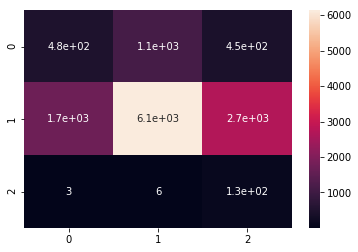

-----------------------------------------------------------------------------------------------------
best_valid_f1_score： 0.3314573944006209
保存模型
Epoch: 2  | time in 0 minutes, 54 seconds
	 训练集
	Loss: 18.3086
	precison_score： [0.36375585 0.36648586 0.3882712 ]
	recall_score： [0.19077162 0.60530384 0.29997053]
	f1_score： [0.25028261 0.45655001 0.33845642]
	f1_score： 0.3484296827967878


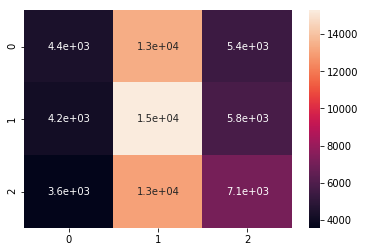

	 验证集
	Loss: 4.1951
	precison_score： [0.44595822 0.46686871 0.31909701]
	recall_score： [0.21904974 0.62194898 0.37263983]
	f1_score： [0.29379207 0.53336481 0.34379622]
	f1_score： 0.39031770052831954


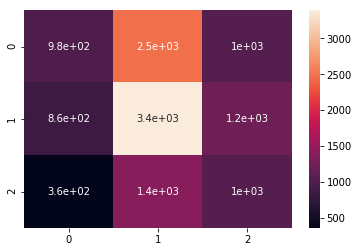

-----------------------------------------------------------------------------------------------------
Epoch: 3  | time in 0 minutes, 53 seconds
	 训练集
	Loss: 10.3861
	precison_score： [0.3643309  0.37027792 0.39791803]
	recall_score： [0.19030251 0.61050216 0.30922028]
	f1_score： [0.25001409 0.46097076 0.34800639]
	f1_score： 0.3529970813273879


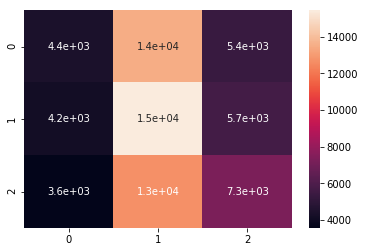

	 验证集
	Loss: 3.4691
	precison_score： [0.63260672 0.30155669 0.37461867]
	recall_score： [0.21643878 0.63837854 0.42727905]
	f1_score： [0.32252836 0.40961826 0.39921977]
	f1_score： 0.3771221308166115


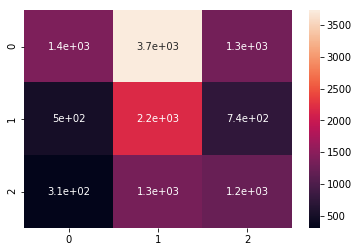

-----------------------------------------------------------------------------------------------------
Epoch: 4  | time in 0 minutes, 52 seconds
	 训练集
	Loss: 11.5330
	precison_score： [0.36630247 0.37334997 0.40903641]
	recall_score： [0.19126668 0.61449733 0.31856191]
	f1_score： [0.25131038 0.46448993 0.35817405]
	f1_score： 0.35799145265690546


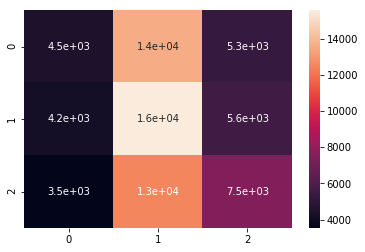

	 验证集
	Loss: 3.2594
	precison_score： [0.50408719 0.42815815 0.37278829]
	recall_score： [0.22129187 0.64871634 0.41678035]
	f1_score： [0.30756442 0.51585062 0.39355878]
	f1_score： 0.40565794028391666


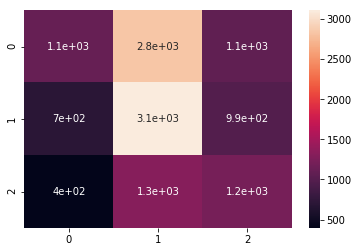

-----------------------------------------------------------------------------------------------------


In [ ]:
N_EPOCHS = 10
best_valid_f1_score = float('inf')

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss(weight=weight).to(device)
optimizer = torch.optim.SGD(model_rnn.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_output, train_cls = train_func(model_rnn, train_iter)
    valid_loss, val_output, val_cls = evaluate(model_rnn, val_iter)    
    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60
    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print('\t 训练集')
    _ = evaluation_indicators(train_loss, train_output, train_cls)
    print('\t 验证集')
    valid_f1_score = evaluation_indicators(valid_loss, val_output, val_cls)
    print('-----------------------------------------------------------------------------------------------------')
    if valid_f1_score < best_valid_f1_score:
        best_valid_f1_score = valid_f1_score
        print('best_valid_f1_score：', best_valid_f1_score)
        print('保存模型')
        torch.save(model_rnn.state_dict(), 'model_rnn.pt')

test_loss, test_output, test_cls = evaluate(model_rnn, test_iter)    
print('\t 线下测试集')
evaluation_indicators(test_loss, test_output, test_cls)

## test_online

In [194]:
result = get_result(model_rnn, test_online_iter)

In [195]:
result.情感极性.value_counts()

 0    6296
 1    2433
-1    1271
Name: 情感极性, dtype: int64

In [196]:
result.to_csv(r'./result.csv', index=False)

# CNN模型

## 定义模型

In [74]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, n_filters, filter_sizes,output_size, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,
                                      embedding_size,
                                      padding_idx=pad_idx)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1,out_channels=n_filters,kernel_size=(fs, embedding_size)) for fs in filter_sizes])
        # input的形式：(B,C,H,W)
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, tt):
        text = text.permute(1, 0)  # [B, L]
        embedded = self.embedding(text)  # [B, L, EMB_SIZE]
        embedded = embedded.unsqueeze(1)  # [B, 1, L, EMB_SIZE]
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        cat = self.dropout(torch.cat(pooled, dim=1))

        return self.fc(cat)

In [79]:
device = "cuda" if torch.cuda.is_available() else "cpu"

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_SIZE = 300
N_FILTERS = 100
FILTER_SIZES = [3]
OUTPUT_SIZE = 3
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model_cnn = CNN(INPUT_DIM, EMBEDDING_SIZE, N_FILTERS, FILTER_SIZES, OUTPUT_SIZE, DROPOUT, PAD_IDX).to(device)

# 导入预训练的词向量
weight_matrix = TEXT.vocab.vectors  
model_cnn.embedding.weight.data.copy_(weight_matrix )  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1240, -0.0537,  0.1580,  ..., -0.1271, -0.0205,  0.0326],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

In [80]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model_cnn.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_SIZE)
model_cnn.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_SIZE)

print(f'The model_rnn has {count_parameters(model_rnn):,} trainable parameters')

The model_rnn has 25,209,883 trainable parameters


## 训练模型

In [81]:
N_EPOCHS = 10
best_valid_f1_score = float('inf')

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_cnn.parameters())

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_output, train_cls = train_func(model_cnn, train_iter)
    valid_loss, val_output, val_cls = evaluate(model_cnn, val_iter)    
    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60
    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print('\t 训练集')
    _ = evaluation_indicators(train_loss, train_output, train_cls)
    print('\t 验证集')
    valid_f1_score = evaluation_indicators(valid_loss, val_output, val_cls)
    print('-----------------------------------------------------------------------------------------------------')
    if valid_f1_score < best_valid_f1_score:
        best_valid_f1_score = valid_f1_score
        print('best_valid_f1_score：', best_valid_f1_score)
        print('保存模型')
        torch.save(model_cnn.state_dict(), 'model_cnn.pt')

test_loss, tess_output, tess_cls = evaluate(model_cnn, val_iter)    
print('\t 线下测试集')
evaluation_indicators(test_loss, tess_output, tess_cls)

RuntimeError: cuDNN error: CUDNN_STATUS_BAD_PARAM

# 预测模型效果

In [61]:
def predict_sentiment(model, sentence):
    tokennized = tokenizer(sentence)
    indexed = [TEXT.vocab.stoi[t] for t in tokennized]
    tensor = torch.LongTensor(indexed).to(device)
    print(tensor.shape)
    prediction = model(tensor)
    return prediction

In [60]:
predict_sentiment(model, '我感觉很好')

torch.Size([4])


RuntimeError: number of dims don't match in permute